### Implementing RBC, MPC, and SAC in CityLearn

Import packages

In [1]:
# System operations
import inspect
import os
import uuid

# Date and time
from datetime import datetime

# type hinting
from typing import Any, List, Mapping, Tuple, Union

# Data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# User interaction
from IPython.display import clear_output
from ipywidgets import Button, FloatSlider, HBox, HTML
from ipywidgets import IntProgress, Text, VBox

# Data manipulation
from bs4 import BeautifulSoup
import math
import numpy as np
import pandas as pd
import random
import re
import requests
import simplejson as json

# CityLearn
from citylearn.agents.rbc import HourRBC
from citylearn.agents.q_learning import TabularQLearning
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import NormalizedObservationWrapper
from citylearn.wrappers import StableBaselines3Wrapper
from citylearn.wrappers import TabularQLearningWrapper

# baseline RL algorithms
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback

Set settings for plotting

In [2]:
# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
%matplotlib inline

Load data from CityLearn 2021 Challenge. 

In this challenge, the agents must control the energy stored by a micro-grid of 9 buildings in real-time for a period of 4 simulated years, on an hourly time-scale. Each building has up to 3 action-variables (domestic hot water storage, chilled water storage, and electrical storage). This is a coordination challenge, so most of objectives of this control problem depend on the joint actions of all the buildings combined.

In [20]:
DATASET_NAME = 'citylearn_challenge_2021'
schema = DataSet.get_schema(DATASET_NAME)

In [51]:
schema

{'root_directory': '/home/jt9744/.conda/envs/citylearn/lib/python3.9/site-packages/citylearn/data/citylearn_challenge_2021',
 'central_agent': True,
 'simulation_start_time_step': 0,
 'simulation_end_time_step': 17520,
 'episode_time_steps': None,
 'rolling_episode_split': False,
 'random_episode_split': False,
 'seconds_per_time_step': 3600.0,
 'observations': {'month': {'active': True, 'shared_in_central_agent': True},
  'day_type': {'active': True, 'shared_in_central_agent': True},
  'hour': {'active': True, 'shared_in_central_agent': True},
  'daylight_savings_status': {'active': False,
   'shared_in_central_agent': True},
  'outdoor_dry_bulb_temperature': {'active': True,
   'shared_in_central_agent': True},
  'outdoor_dry_bulb_temperature_predicted_6h': {'active': True,
   'shared_in_central_agent': True},
  'outdoor_dry_bulb_temperature_predicted_12h': {'active': True,
   'shared_in_central_agent': True},
  'outdoor_dry_bulb_temperature_predicted_24h': {'active': True,
   'share

Data Preprocessing:
1. Use only 3, 5, 7, or 9 buildings 
2. Use the first two years of data for training, the third year for validation, and the fourth year for testing.
3. Use centralized control

These can be modified directly in the schema. The buildings will be pseudo-randomly selected with a seed for reproducibility. 

In [33]:
def set_schema_buildings(schema, scale='tiny', seed=2025) -> Tuple[dict, List[str]]:
    """Randomly select number of buildings to set as active in the schema.

    Parameters
    ----------
    schema: dict
        CityLearn dataset mapping used to construct environment.
    scale: str
        Number of buildings to set as active in schema. 'tiny' = 3 buildings,
        'small' = 5 buildings, 'medium' = 7 buildings, 'large' = 9 buildings.
    seed: int
        Seed for pseudo-random number generator

    Returns
    -------
    schema: dict
        CityLearn dataset mapping with active buildings set.
    buildings: List[str]
        List of selected buildings.
    """
    scales = ['tiny','small','medium','large']
    assert scale in scales, f'scale must be one of {scales}'
    if scale == 'tiny':
        count = 3
    elif scale =='small':
        count = 5
    elif scale == 'medium':
        count = 7
    elif scale == 'large':
        count = 9 
    assert 1 <= count <= len(schema['buildings']), f"count must be between 1 and {len(schema['buildings'])}."

    # set random seed
    np.random.seed(seed)

    # get all building names
    buildings = list(schema['buildings'].keys())

    # randomly select specified number of buildings
    buildings = np.random.choice(buildings, size=count, replace=False).tolist()

    # reorder buildings
    building_ids = [int(b.split('_')[-1]) for b in buildings]
    building_ids = sorted(building_ids)
    buildings = [f'Building_{i}' for i in building_ids]

    # update schema to only included selected buildings
    for b in schema['buildings']:
        if b in buildings:
            schema['buildings'][b]['include'] = True
        else:
            schema['buildings'][b]['include'] = False

    return schema, buildings

In [41]:
def set_schema_simulation_period(schema, data_split) -> Tuple[dict, int, int]:
    """Select environment simulation start and end time steps based on the data split

    Parameters
    ----------
    schema: dict
        CityLearn dataset mapping used to construct environment.
    data_split: str
        'train', 'val', or 'test'

    Returns
    -------
    schema: dict
        CityLearn dataset mapping with `simulation_start_time_step`
        and `simulation_end_time_step` key-values set.
    simulation_start_time_step: int
        The first time step in schema time series files to
        be read when constructing the environment.
    simulation_end_time_step: int
        The last time step in schema time series files to
        be read when constructing the environment.
    """
    assert data_split in ['train', 'val', 'test'], f"data_split must be one of {['train', 'val', 'test']}"

    # use any of the files to determine the total
    # number of available time steps
    filename = schema['buildings']['Building_1']['carbon_intensity']
    filepath = os.path.join(schema['root_directory'], filename)
    time_steps = pd.read_csv(filepath).shape[0]

    # select a simulation start and end time step
    if data_split == 'train':
        simulation_start_time_step = 0
        simulation_end_time_step = 2*365*24
    elif data_split == 'val': 
        simulation_start_time_step = 2*365*24
        simulation_end_time_step = 3*365*24
    elif data_split == 'test':
        simulation_start_time_step = 3*365*24
        simulation_end_time_step = time_steps-1

    # update schema simulation time steps
    schema['simulation_start_time_step'] = simulation_start_time_step
    schema['simulation_end_time_step'] = simulation_end_time_step

    return schema, simulation_start_time_step, simulation_end_time_step

Setting the Buildings and Time Periods to use in Simulations from the Schema

In [43]:
# edit next code line to change number of buildings in simulation
scale = 'tiny'

 # edit next code line to change number of days in simulation
split = 'train'

# edit next code line to change active observations in simulation
ACTIVE_OBSERVATIONS = ['hour']

schema, buildings = set_schema_buildings(schema, scale)
schema, simulation_start_time_step, simulation_end_time_step =\
    set_schema_simulation_period(schema, split)

print('Selected buildings:', buildings)
print(
    f'Selected {split} split:',
    (simulation_start_time_step, simulation_end_time_step)
)
print(f'Active observations:', ACTIVE_OBSERVATIONS)

Selected buildings: ['Building_2', 'Building_6', 'Building_9']
Selected train split: (0, 17520)
Active observations: ['hour']


The choice between either control strategy is set using the `central_agent` parameter in CityLearn, which is a key-value in the `schema`. Use the centralized control strategy:

In [45]:
schema['central_agent'] = True

Initialize a CityLearn Environment

In [47]:
env = CityLearnEnv(schema)

Check initalization

In [48]:
print('Current time step:', env.time_step)
print('environment number of time steps:', env.time_steps)
print('environment uses central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))

Current time step: 0
environment number of time steps: 17521
environment uses central agent: True
Number of buildings: 3


In [50]:
# electrical storage
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Electrical storage loss_coefficient:', {
    b.name: b.electrical_storage.loss_coefficient for b in env.buildings
})
print('Electrical storage initial_soc:', {
    b.name: b.electrical_storage.initial_soc for b in env.buildings
})
print('Electrical storage efficiency:', {
    b.name: b.electrical_storage.efficiency for b in env.buildings
})
print('Electrical storage electricity consumption:', {
    b.name: b.electrical_storage.electricity_consumption[b.time_step]
    for b in env.buildings
})
print()

# pv
print('PV nominal power:', {
    b.name: b.pv.nominal_power for b in env.buildings
})
print()

# active observations and actions
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None
):
    print('Active observations:')
    display(pd.DataFrame([
        {**{'building':b.name}, **b.observation_metadata}
        for b in env.buildings
    ]))
    print()
    print('Active actions:')
    display(pd.DataFrame([
        {**{'building':b.name}, **b.action_metadata}
        for b in env.buildings
    ]))

Electrical storage capacity: {'Building_2': 80.0, 'Building_6': 30.0, 'Building_9': 35.0}
Electrical storage loss_coefficient: {'Building_2': 0.0, 'Building_6': 0.0, 'Building_9': 0.0}
Electrical storage initial_soc: {'Building_2': 0.0, 'Building_6': 0.0, 'Building_9': 0.0}
Electrical storage efficiency: {'Building_2': 0.9, 'Building_6': 0.9, 'Building_9': 0.9}
Electrical storage electricity consumption: {'Building_2': 0.0, 'Building_6': 0.0, 'Building_9': 0.0}

PV nominal power: {'Building_2': 0.0, 'Building_6': 20.0, 'Building_9': 0.0}

Active observations:


,building,month,day_type,hour,daylight_savings_status,outdoor_dry_bulb_temperature,outdoor_dry_bulb_temperature_predicted_6h,outdoor_dry_bulb_temperature_predicted_12h,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h,carbon_intensity,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,solar_generation,cooling_storage_soc,heating_storage_soc,dhw_storage_soc,electrical_storage_soc,net_electricity_consumption,electricity_pricing,electricity_pricing_predicted_6h,electricity_pricing_predicted_12h,electricity_pricing_predicted_24h,power_outage
0,Building_2,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,False,True,True,True,False,False,False,False,False
1,Building_6,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,False,False,False,False,False
2,Building_9,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,False,True,True,True,False,False,False,False,False



Active actions:


,building,cooling_storage,heating_storage,dhw_storage,electrical_storage
0,Building_2,True,False,True,True
1,Building_6,True,False,True,True
2,Building_9,True,False,True,True


Given a set of GEBs, the controllers aim to minimize the electricity cost, average peak demand, and carbon intensity of electricity consumed by the buildings. The evalu
tion will be based on these metrics while also including computational costs suchas 
 training time, inference time, RAM usage, and scalability across different numbe off
 builgs.

Three built-in key performance indicators can be used: cost, carbon emissions, and average daily peak. Average daily peak is a district-level KPI that is calculated using the aggregated district-level hourly net electricity consumption (kWh), $E_h^{\textrm{district}}$. Cost and carbon emissions are building-level KPIs that are calculated using the building-level hourly net electricity consumption (kWh), $E_h^{\textrm{building}}$, and are reported at the grid level as the average of the building-level values.

Cost is defined as the sum of building-level imported electricity cost, $E_h^{\textrm{building}} \times T_h$ (\$), where $T_h$ is the electricity rate at hour $h$.

$$
    \textrm{cost} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times T_h \right )}
$$

Carbon emissions is the sum of building-level carbon emissions (kg<sub>CO<sub>2</sub>e</sub>), $E_h^{\textrm{building}} \times O_h$, where $O_h$ is the carbon intensity (kg<sub>CO<sub>2</sub>e</sub>/kWh) at hour $h$.

$$
    \textrm{carbon emissions} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times O_h \right )}
$$

Average daily peak, is defined as the mean of the daily $E_h^{\textrm{district}}$ peak where $d$ is the day index and $n$ is the total number of days.

$$
    \textrm{average daily peak} = \frac{
        {\sum}_{d=0}^{n - 1} {\sum}_{h=0}^{23} {\textrm{max} \left (E_{24d + h}^{\textrm{district}}, \dots, E_{24d + 23}^{\textrm{district}} \right)}
    }{n}
$$

The KPIs are reported as normalized values with respect to the baseline outcome where the baseline outcome is when buildings are not equipped with batteries i.e., no control.

$$\textrm{KPI} = \frac{{\textrm{KPI}_{control}}}{\textrm{KPI}_{baseline (no\ battery)}}
$$

Helper functions to parse and illustrate the KPIs from CityLearn.

In [68]:
from kpi_utils import get_kpis, plot_building_kpis, plot_district_kpis
from kpi_utils import plot_building_load_profiles, plot_district_load_profiles, plot_battery_soc_profiles, plot_simulation_summary

# Build your Custom Rule-Based Controller
---

With our convenience functions defined, we are ready to start solving our earlier described control problem.

We will start simple with a rule-based control (RBC) agent that you will build yourself! RBC is a popular control strategy that is used in most systems e.g. HVAC, batteries, etc because of their level of simplicity. They are  best described as a set of rules expressed as if-else statements and conditions that guide their decision making. An example of such statement is `if outdoor dry-bulb temperature is 20 degrees Celcius and hour 10 PM, charge battery with 5% of capacity`. Now the actual implementation of this statement is open-ended as a designer can choose to program it using any programming language e.g. Python (as used in CityLearn) or a proprietary language that the battery manufacturer uses. Nevertheless, at a high-level, it simplifies to a set of statements and conditions that are easily understood and mappable (think decision tree in supervised learning).

The RBC you will be designing here, is a set of if-else statements that use the `hour` observation to determine the amount of energy to charge or discharge a battery. Remember we are using a centralized control strategy thus, the if-else statements you define will apply to all batteries in all buildings.

We will use widgets for an interactive RBC tuning experience. You will design a custom RBC that inherits from an existing RBC in CityLearn called the [HourRBC](https://www.citylearn.net/api/citylearn.agents.rbc.html#citylearn.agents.rbc.HourRBC). Inheritance, allows us to copy existing properties and methods in the parent class, `HourRBC`, into our custom class. The `HourRBC` class allows one to define a custom `action_map` using the `hour` as the `if-else` condition and the battery capacity proportion as the `action` where negative proportions imply discharging and positive proportions imply charging.

We begin by initializing the environment we will work with:

In [32]:
rbc_env = CityLearnEnv(schema)

Now let us define the custom RBC class we will use. All agent classes in CityLearn inherit from the [citylearn.agents.base.Agent](https://www.citylearn.net/api/citylearn.agents.base.html#citylearn.agents.base.Agent) class. This base class has 4 methods that are important to note when defining a new class that inherits from it. namely:

1. `__init__` - Used to initialize a new agent with a `citylearn.citylearn.CityLearnEnv` object.
2. `learn`: Used to train the initialized object on its environment object.
3. `predict`: Used to select actions at each simulation timestep using a defined policy that may be rule-based, reinforcement learning-based or model predictive control-based. The base class selects random actions.
4. `update`: Used to update replay buffers, networks and policies at least every timestep. The base class does not perform any updates.
5. `next_time_step`: Used to proceed to the next timestep and is called inside `predict`. This function is where class values or custom values that need to collected or updated are best manipulated.

In our case with the RBC, we want to include an `action_map` class instance that is a `dict` type. This `action_map` has `int` keys that define hours and `float` values that define charge/discharge action for the hour key that maps them.

We also want to include a loader variable to help us visualize the simulation progress. The loader is an `IntProgress` ipywidgets object. We will update the loader's value each timestep the `next_time_step` method is called in the RBC class.

The RBC class is defined below:

In [33]:
class CustomRBC(HourRBC):
   def __init__(
       self, env: CityLearnEnv, action_map: Mapping[int, float] = None,
       loader: IntProgress = None
    ):
      r"""Initialize CustomRBC.

      Parameters
      ----------
      env: Mapping[str, CityLearnEnv]
         CityLearn environment instance.
      action_map: Mapping[int, float]
         Mapping of hour to control action.
      loader: IntProgress
         Progress bar.
      """

      super().__init__(env=env, action_map=action_map)
      self.loader = loader

   def next_time_step(self):
      r"""Advance to next `time_step`."""

      super().next_time_step()

      if self.loader is not None:
         self.loader.value += 1
      else:
         pass

We can now initialize the RBC by setting all actions to 0 for every hour:

In [34]:
action_map = {i: 0.0 for i in range(1, 25)}
rbc_model = CustomRBC(env=rbc_env, action_map=action_map)
print('default RBC action map:', action_map)

default RBC action map: {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0}


We also need to define a convenience function to set and return a loader i.e. a progress bar as we will use this visualization a number of times to track our learning progress:

In [35]:
def get_loader(**kwargs):
    """Returns a progress bar"""

    kwargs = {
        'value': 0,
        'min': 0,
        'max': 10,
        'description': 'Simulating:',
        'bar_style': '',
        'style': {'bar_color': 'maroon'},
        'orientation': 'horizontal',
        **kwargs
    }
    return IntProgress(**kwargs)

With our custom RBC now defined, we can set up the interactive widgets.

> ⚠️ **NOTE**:
> You do not need to understand the content of the next code cell where the widget is defined. Instead wait for the widgets to load and interact with it using the instructions.

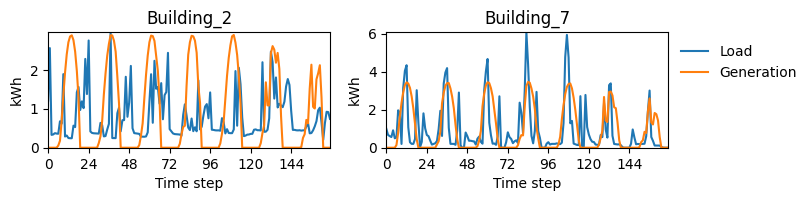

HTML(value='\n<h1>Custom RBC Tuner</h1>\n<p>Use this interactive widget to tune your custom RBC!\nReference th…

IntProgress(value=0, description='Waiting', max=10, style=ProgressStyle(bar_color='maroon'))

In [36]:
action_step = 0.05
hour_step = 2
hours = list(range(1, 25, hour_step))
default_loader_description = 'Waiting'
questions = """
<h1>Custom RBC Tuner</h1>
<p>Use this interactive widget to tune your custom RBC!
Reference the building load profiles above and the questions below when
deciding on how to charge/discharge your rule-based controlled batteries.</p>

<h3>Some considerations when tuning your custom RBC:</h3>
<ul>
    <li>What happens when actions for all hours are set to 0?</li>
    <li>How can we set the RBC so that it takes advantage
    of solar generation?</li>
    <li>Can you spot the duck curve?</li>
    <li>What settings work best for a specific building?</li>
    <li>What settings work best for the entire district?</li>
    <li>Can you tune the RBC to target improvements in any one of
    the evaluation KPIs?</li>
    <li>What challenges can you identify from this RBC tuning process?</li>
</ul>

<h3>Interact with the controls to tune your RBC:</h3>

<p>Use the sliders to set the hourly charge and discharge rate
of the batteries. Positive values indicate charging
and negative values indicate discharging the batteries</p>
"""
html_ui = HTML(value=questions, placeholder='Questions')
sliders = [FloatSlider(
    value=0.0,
    min=-1.0,
    max=1.0,
    step=action_step,
    description=f'Hr: {h}-{h + hour_step - 1}',
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.2f',
) for h in hours]
reset_button = Button(
    description='Reset', disabled=False, button_style='info',
    tooltip='Set all hour actions to 0.0', icon=''
)
random_button = Button(
    description='Random', disabled=False, button_style='warning',
    tooltip='Select random hour actions', icon=''
)
simulate_button = Button(
    description='Simulate', disabled=False, button_style='success',
    tooltip='Run simulation', icon='check'
)
sliders_ui = HBox(sliders)
buttons_ui = HBox([reset_button, random_button, simulate_button])

# run simulation so that the environment has results
# even if user does not interact with widgets
sac_episodes = 1
rbc_model.learn(episodes=sac_episodes)

loader = get_loader(description=default_loader_description)

def plot_building_guide(env):
    """Plots building load and generation profiles."""

    column_count_limit = 4
    building_count = len(env.buildings)
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.5*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, (ax, b) in enumerate(zip(fig.axes, env.buildings)):
        y1 = b.energy_simulation.non_shiftable_load
        y2 = b.pv.get_generation(b.energy_simulation.solar_generation)
        x = range(len(y1))
        ax.plot(x, y1, label='Load')
        ax.plot(x, y2, label='Generation')
        ax.set_title(b.name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('kWh')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

    return fig

def on_reset_button_clicked(b):
    """Zeros sliders and loader values."""

    loader.value = 0
    loader.description = default_loader_description

    for s in sliders:
        s.value = 0.0

def on_random_button_clicked(b):
    """Zeros loader value and sets sliders to random values."""

    loader.value = 0
    loader.description = default_loader_description
    options = np.arange(-1.0, 1.0, action_step)

    for s in sliders:
        s.value = round(random.choice(options), 2)

def on_simulate_button_clicked(b):
    """Runs RBC simulation using selected action map."""

    loader.description = 'Simulating'
    loader.value = 0
    clear_output(wait=False)

    # plot building profiles
    _ = plot_building_guide(rbc_env)
    plt.show()

    display(html_ui, sliders_ui, buttons_ui, loader)
    reset_button.disabled = True
    random_button.disabled = True
    simulate_button.disabled = True

    for s in sliders:
        s.disabled = True

    action_map = {}

    for h, s in zip(hours, sliders):
        for i in range(hour_step):
            action_map[h + i] = s.value

    loader.max = rbc_env.time_steps*sac_episodes
    rbc_model.action_map = action_map
    rbc_model.learn(episodes=sac_episodes)

    loader.description = 'Finished'
    plot_simulation_summary({'RBC': rbc_env})

    reset_button.disabled = False
    random_button.disabled = False
    simulate_button.disabled = False

    for s in sliders:
        s.disabled = False

reset_button.on_click(on_reset_button_clicked)
random_button.on_click(on_random_button_clicked)
simulate_button.on_click(on_simulate_button_clicked)

# plot building profiles
_ = plot_building_guide(rbc_env)
plt.show()

# preview of building load profile
display(html_ui, sliders_ui, buttons_ui, loader)

# An Introduction to Tabular Q-Learning Algorithm as an Adaptive Controller
---

Tuning your RBC must have revealed that it is a cumbersome and labor intensive process, especially as the number of buildings, time period and variance in load profiles increase. What we will be ideal is an adaptive controller that can adjust to different occupant preferences and behaviors in each building that influence load profiles and adjust to different weather conditions that affect the seasonal variance in load profiles.

Moreover, we want a controller that is able to learn with little to no knowledge about the environment model it is controlling unlike the RBC tuning process where you probably chose your charge and discharge proportion by visually inspecting the building load and generation profiles. Instead, we want a controller that can learn those patterns in a data-driven fashion.

## Q-Learning Background
[Tabular Q-Learning](https://link.springer.com/article/10.1007/BF00992698) is a popular model-free reinforcement learning technique due to its simplicity. In simple tasks with small finite state sets, and discrete actions, all transitions can be represented using a table, hence the name Tabular Q-Learning, which stores the state-action values, i.e., Q-values.

After taking an action $a$, given a state $s$, and observing the immediate reward $r$ for taking $a$ at $s$, learning is achieved through updating $Q(s, a)$ ([Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation)) as:

$$
Q(s, a) = Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]
$$

where $Q(s, a)$ is the Q-value for taking action $a$ in state $s$, $\alpha ∈ [0, 1]$ is the learning rate, which explicitly defines to what degree new knowledge overrides old knowledge: for $\alpha = 0$, no learning happens, while for $\alpha = 1$, all prior knowledge is lost. $\gamma$ is the discount factor which allow to balance between an agent that considers only immediate rewards ($\gamma$ = 0) and one that strives towards long term rewards ($\gamma$ = 1). $\max_{a'} Q(s', a')$ is the maximum Q-value for all actions $a'$ in the next state $s'$ that is reached after taking action $a$ in state $s$.

In other words, the optimal policy, $\pi$, results from taking those actions $a$ that maximize the respective Q-values in each state, $s$. In order for the algorithm to converge to the optimal policy, the requirement is that each state-action pair $(s, a)$ be visited infinitely many times, such that the Q-values have converged.

### Algorithm

The general Q-Learning algorithm is as follows:

> 1. Initialize the Q-table for all state-action pairs.
> 2. Set the learning rate $\alpha$ ($0 < \alpha < 1$) and the discount factor $\gamma$ ($0 < \gamma < 1$).
> 3. Repeat the following steps for each episode:
>     - Observe the initial state $s$.
>     - Choose an action $a$ based on the epsilon-greedy policy (a random action is chosen with probability epsilon, $\epsilon$ and the action with the highest Q-value is chosen with probability $1 - \epsilon$).
>     - Take the action $a$ and observe the next state $s'$ and the reward $r$.
>     - Update the Q-value of the state-action pair $(s,a)$ using the Bellman equation.
>     - Set $s = s'$.
> 4. Repeat step 3 for a large number of episodes or until convergence is reached.

### Action Selection

In Q-learning, the process of accumulating knowledge happens through the trade-off between exploiting known, high-reward, actions, and exploring other, unknown, actions that have not been executed yet under that state. The $\epsilon$-greedy approach which we use here, selects a random action with probability epsilon, $\epsilon$ (exploration), and the action with the highest expected return with probability $1 - \epsilon$ (exploitation). This balancing allows the agent to avoid local minima (exploration), while striving towards convergence (exploitation). In practice, $\epsilon$ is set relatively large in the beginning of the learning process, and then reduced progressively. The choice of the initial value and the reduction strategy is domain specific and task of the designer.

## CityLearn Tabular Q-Learning Implementation

CityLearn has a Tabular Q-learning implementation in its `citylearn.agents.q_learning.TabularQLearning` class (see [docs](https://www.citylearn.net/api/citylearn.agents.base.html#citylearn.agents.q_learning.TabularQLearning)). This Q-Learning implementation is inspired by the [BOPTEST Tutorial](https://colab.research.google.com/drive/1WeA_3PQeySba0MMRRte_oZTF7ptlP_Ra#scrollTo=9U81QUVcUfoW&line=17&uniqifier=1) but follows the general algorithm in the literature that we have described. However, a caveat of making use of this agent is that it requires discrete observations and actions in order to update the Q-Table whereas the default CityLearn environment provides continuous observations and actions.

CityLearn provides an environment wrapper, `TabularQLearningWrapper` (see [docs](https://www.citylearn.net/api/citylearn.wrappers.html#citylearn.wrappers.DiscreteSpaceWrapper)) used to discretize observations and actions before passing to an agent. All we need to do is define the number of bins to use to discretize the observations and actions using the wrapper's `observation_bin_sizes` and `action_bin_sizes` initialization variables.

We begin by initializing a new environment:

In [37]:
tql_env = CityLearnEnv(schema)

We will discretize the hour into 24 bins and the action into 12 bins. Hour is an observation shared by all buildings thus, its values are the same in all buildings at each time step. For this reason, one of the dimensions of our Q-Table will equal the hour bin count. The action space for controlling the batteries has the same size as number of buildings thus when discretized, the other Q-Table dimension will equal the `electrical_storage` action raised to the power of building count:

In [38]:
# define active observations and actions and their bin sizes
observation_bins = {'hour': 24}
action_bins = {'electrical_storage': 12}

# initialize list of bin sizes where each building
# has a dictionary in the list definining its bin sizes
observation_bin_sizes = []
action_bin_sizes = []

for b in tql_env.buildings:
    # add a bin size definition for the buildings
    observation_bin_sizes.append(observation_bins)
    action_bin_sizes.append(action_bins)

Can you think of a way to choose more appropriate bin sizes? How does the choice of bin size affect the learning process?

Now we wrap the environment to make sure we are exchanging discrete observations and actions between the environment and agent:

In [39]:
tql_env = TabularQLearningWrapper(
    tql_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

We can now go ahead to initialize our Q Learner. We will modify the CityLearn `TabularQLearning` class like we did the `HourRBC` so that we are able to visually track the learning process as well as keep tabs on its cummulative reward as training episodes go by. We also provide a `random_seed` instance variable that we set to the random seed you defined earlier. This random seed will ensure that each time this notebook is run, the epsilon-greedy action selections are reproducible. The modifications to the `TabularQLearning` class are done below:

In [40]:
class CustomTabularQLearning(TabularQLearning):
    def __init__(
        self, env: CityLearnEnv, loader: IntProgress,
        random_seed: int = None, **kwargs
    ):
        r"""Initialize CustomRBC.

        Parameters
        ----------
        env: Mapping[str, CityLearnEnv]
            CityLearn environment instance.
        loader: IntProgress
            Progress bar.
        random_seed: int
            Random number generator reprocucibility seed for
            eqsilon-greedy action selection.
        kwargs: dict
            Parent class hyperparameters
        """

        super().__init__(env=env, random_seed=random_seed, **kwargs)
        self.loader = loader
        self.reward_history = []

    def next_time_step(self):
        if self.env.time_step == 0:
            self.reward_history.append(0)

        else:
            self.reward_history[-1] += sum(self.env.rewards[-1])

        self.loader.value += 1
        super().next_time_step()

With our Tabular Q-Learning agent set up, it is time to train it on our environment. We will use the following hyperparameters:

- `epsilon` ($\epsilon$) = 1.0
- `minimum_epsilon` ($\epsilon_{\textrm{min}}$) = 0.01
- `epsilon_decay` ($\epsilon_{\textrm{decay}}$) = 0.0001
- `discount_factor` ($\gamma$) = 0.99
- `learning_rate` ($\alpha$) = 0.005

The agent is trained for $\frac{m \times n \times i}{t}$ episodes where $m$ and $n$ are the observation and action space sizes respectively, $i$ is an arbitrary integer and t is the number of time steps in one episode. That way, we increase the probability that we at least visit each state-action combination once.

In [41]:
# ----------------- CALCULATE NUMBER OF TRAINING EPISODES -----------------
i = 3
m = tql_env.observation_space[0].n
n = tql_env.action_space[0].n
t = tql_env.time_steps - 1
tql_episodes = m*n*i/t
tql_episodes = int(tql_episodes)
print('Q-Table dimension:', (m, n))
print('Number of episodes to train:', tql_episodes)

# ------------------------------- SET LOADER ------------------------------
loader = get_loader(max=tql_episodes*t)
display(loader)

# ----------------------- SET MODEL HYPERPARAMETERS -----------------------
tql_kwargs = {
    'epsilon': 1.0,
    'minimum_epsilon': 0.01,
    'epsilon_decay': 0.0001,
    'learning_rate': 0.005,
    'discount_factor': 0.99,
}

# ----------------------- INITIALIZE AND TRAIN MODEL ----------------------
tql_model = CustomTabularQLearning(
    env=tql_env,
    loader=loader,
    random_seed=RANDOM_SEED,
    **tql_kwargs
)
_ = tql_model.learn(episodes=tql_episodes)

Q-Table dimension: (24, 144)
Number of episodes to train: 62


IntProgress(value=0, description='Simulating:', max=10354, style=ProgressStyle(bar_color='maroon'))

ValueError: not enough values to unpack (expected 2, got 1)

We now evaluate the trained model:

In [ ]:
observations = tql_env.reset()

while not tql_env.done:
    actions = tql_model.predict(observations, deterministic=True)
    observations, _, _, _ = tql_env.step(actions)

# plot summary and compare with other control results
plot_simulation_summary({'RBC': rbc_env, 'TQL': tql_env})

The figures plotted for the Tabular Q-Learning are compared against the baseline and your tuned RBC. The Q-Learning agent has performed worse than the baseline and RBC in terms of the building-level and district-level KPIs. The net electricity consumption profile as a result of the Q-Learning agent shows unstable and spiky consumption. The reason for this behavior is seen in the battery SoC curves where the changes in SoC are abrupt. This highlights an issue with our discretized action space having too large steps as trade off for maintaining a reasonably-sized Q-Table. We also see that the agent did not learn the unique day-to-day building needs as the SoC profile is identical every 24 time steps. This is a consequence of using a single observation, `hour` to learn.

For the buildings 2 and 7 selected when the `RANDOM_SEED` = 0, we see that agent learned to charge the battery in building 2 in the early morning just after midnight and slightly charged and discharges during the day before completely depleting charge by midnight and into the early early hours if the next day. Building 7 on the other hand has 2 charge-discharge cycles each day that are split around noon.

Since the Q-Table is 2 dimensional, we can visualize and spot the the state-action combinations that maximize the Q-value below:

In [ ]:
def plot_table(
    ax: plt.Axes, table: np.ndarray, title: str, cmap: str,
    colorbar_label: str, xlabel: str, ylabel: str
) -> plt.Axes:
    """Plot 2-dimensional table on a heat map.

    Parameters
    ----------
    ax: plt.Axes
        Figure axes
    table: np.ndarray
        Table array
    title: str
        axes title
    cmap: str
        Colormap
    colorbar_label: str
        Colorbar name
    xlabel: str
        Heat map x-axis label
    ylabel: str
        Heat map y-axis label

    Returns
    -------
    ax: plt.Axes
        Plotted axes
    """

    x = list(range(table.shape[0]))
    y = list(range(table.shape[1]))
    z = table.T
    pcm = ax.pcolormesh(
        x, y, z, shading='nearest', cmap=cmap,
        edgecolors='black', linewidth=0.0
    )
    _ = fig.colorbar(
        pcm, ax=ax, orientation='horizontal',
        label=colorbar_label, fraction=0.025, pad=0.08
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    return ax

In [ ]:
cmap = 'coolwarm'
figsize = (12, 8)
fig, axs = plt.subplots(1, 3, figsize=figsize, sharey=True)
axs[0] = plot_table(
    axs[0], tql_model.q[0], 'Q-Table',
    cmap, 'Q-Value', 'State (Hour)', 'Action Index'
)
axs[1] = plot_table(
    axs[1], tql_model.q_exploration[0], 'Q-Table Exploration',
    cmap, 'Count', 'State (Hour)', None
)
axs[2] = plot_table(
    axs[2], tql_model.q_exploitation[0], 'Q-Table Exploitation',
    cmap, 'Count', 'State (Hour)', None
)

plt.tight_layout()
plt.show()

The Q-Table (left) shows that for each hour, the Q-Values for most action indices are similar and very low (dark blue) asides the one action index that has been exploited. The middle heat map shows how many times each state-action pair was explored i.e. randomly chosen using $\epsilon$, and we see that while most pairs have been visited at least once, some pairs have the monopoly. The figure on the right shows how many times state-action pairs were exploited. For each state, only one action was ever an exploitation candidate. This shows that the algorithm spent much time exploring randomly and the first discovered exploitation candidate for each state remained till learning was terminated. We can tell the exploration-exploitation balance through $\epsilon$:

In [ ]:
print(
    f'Current Tabular Q-Learning epsilon after {tql_episodes}'\
        f' episodes and {tql_model.time_step} time steps:', tql_model.epsilon
)

Epsilon is still high so there is a higher probability of random exploration. The Q-Learning agent updates epsilon using the following exponential decay formula:

$$
\epsilon = \textrm{max}(\epsilon_{\textrm{minimum}}, \epsilon_{0} \cdot e^{-\epsilon_{\textrm{decay}}*\textrm{episode}})
$$

where $\epsilon_{0}$ is $\epsilon$ at time step 0. Thus with the current decay rate, $\epsilon_{\textrm{decay}}$ we can visualize the number of episodes needed to get to at least 50-50 probability of exploration-exploitation:  

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
y = np.array([max(
    tql_model.minimum_epsilon,
    tql_model.epsilon_init*np.exp(-tql_model.epsilon_decay*e)
) for e in range(100_000)])
ref_x = len(y) - len(y[y <= 0.5]) - 1
ref_y = y[ref_x]
ax.plot(y)
ax.axvline(ref_x, color='red', linestyle=':')
ax.axhline(ref_y, color='red', linestyle=':')
ax.axvline(tql_episodes, color='green', linestyle=':')
ax.set_xlabel('Episode')
text = f'{ref_x} training episodes needed to get\nat least 50%'\
    ' exploitation probability.'
ax.text(ref_x + 1000, ref_y + 0.05, text, color='red')
ax.text(
    tql_episodes + 1000,
    ref_y - 0.1,
    f'Current training episodes = {tql_episodes}',
    va='bottom', color='green'
)
ax.set_ylabel(r'$\epsilon$')
plt.show()

Now that we have experimented with the Tabular Q-Learning algorithm, what issues can you identify with this control approach? Ponder on these questions:

1. How do the observations we use affect learning?
2. How does the table dimension affect learning?
4. What can we do to ensure that there is enough exploration of all state-action pairs?
6. In what building control applications/examples could Tabular Q-Learning work well?
7. In what building applications/examples will Tabular Q-Learning most likely fail?

## Replacing the Q-Table with a Function Approximator

Tabular Q-Learning is affected by the curse of dimensionality: as the size of the state space increases due to, e.g., continuous sensor inputs, the size of the Q-table has to necessarily increase is well. In particular for building control, the curse of dimensionality is significant, considering the potentially large number of sensors measuring various quantities (temperature, humidity, energy consumption, etc.) continuously. This means that the agent has an exponentially increasing number of state-action pairs to explore before it can converge to an optimal solution. Function approximators, e.g., linear regression or artificial neural networks ([Haykin (2009)](https://www.pearson.com/en-us/subject-catalog/p/neural-networks-and-learning-machines/P200000003278/9780133002553)), have been proposed as solutions that allow generalization by directly mapping the state-action pairs, $(s, a)$, to their respective Q-value, $Q(s, a)$. Refer to [Reinforcement learning for intelligent environments](https://www.taylorfrancis.com/chapters/edit/10.4324/9781315142074-37/reinforcement-learning-intelligent-environments-zoltan-nagy-june-young-park-josé-ramón-vázquez-canteli) for more information on how to make use of function approximators to improve learning in reinforcement learning control (RLC).

In the next section, we will introduce the soft-actor critic (SAC) algorithm, which is a model-free Q-Learning algorithm, that uses a neural network to approximate the Q-values thus, reducing the cost of training compared to Tabular Q-Learning.

# Optimize a Soft-Actor Critic Reinforcement Learning Controller
---

To control an environment like CityLearn that has continuous states and actions, tabular Q-learning is not practical, as it suffers from the _curse of dimensionality_. Actor-critic reinforcement learning (RL) methods use artificial neural networks to generalize across the state-action space. The actor network maps the current states to the actions that it estimates to be optimal. Then, the critic network evaluates those actions by mapping them, together with the states under which they were taken, to the Q-values.

<figure class="image">
  <img src="https://github.com/intelligent-environments-lab/CityLearn/blob/master/assets/images/sac_schematic.png?raw=true"  width="350" alt="SAC networks overview.">
  <figcaption>Figure: SAC networks overview (adopted from <a href="https://doi.org/10.1145/3408308.3427604">Vazquez-Canteli et al., 2020</a>).</figcaption>
</figure>

Soft actor-critic (SAC) is a model-free off-policy RL algorithm. As an off-policy method, SAC can reuse experience and learn from fewer samples. SAC is based on three key elements: an actor-critic architecture, off-policy updates, and entropy maximization for efficient exploration and stable training. SAC learns three different functions: the actor (policy), the critic (soft Q-function), and the value function.

This tutorial does not dive into the theory and algorithm of SAC but for interested participants please, refer to [Soft Actor-Critic Algorithms and Applications](https://doi.org/10.48550/arXiv.1812.05905).

We will now initialize a new environment and plug it to an SAC agent to help us solve our control problem. Luckily, we do not have to write our own implementation of the SAC algorithm. Instead, we can make use of Python libraries that have standardized the implementation of a number of RL algorithms. One of such libraries that we will use is [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/index.html). At the time of writing, there are [13 different RL algorithms](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html#rl-algorithms) implemented between Stable Baselines3 and Stable-Baselines3 - Contrib (contrib package for Stable-Baselines3 - experimental reinforcement learning code), including SAC.

The new environment is initialized below:

In [42]:
sac_env = CityLearnEnv(schema)

Before our environment is ready for use in Stable Baselines3, we need to take a couple of preprocessing steps in the form of wrappers. Firstly, we will wrap the environment using the `NormalizedObservationWrapper` (see [docs](https://www.citylearn.net/api/citylearn.wrappers.html#citylearn.wrappers.NormalizedObservationWrapper)) that ensure all observations that are served to the agent are [min-max normalized](https://www.codecademy.com/article/normalization) between [0, 1] and cyclical observations e.g. hour, are encoded using the [sine and cosine transformation](https://www.avanwyk.com/encoding-cyclical-features-for-deep-learning/).

In [43]:
sac_env = NormalizedObservationWrapper(sac_env)

Next, we wrap with the `StableBaselines3Wrapper` (see [docs](https://www.citylearn.net/api/citylearn.wrappers.html#citylearn.wrappers.StableBaselines3Wrapper)) that ensures observations, actions and rewards are served in manner that is compatible with Stable Baselines3 interface:

In [44]:
sac_env = StableBaselines3Wrapper(sac_env)

Now we can go ahead and initialize the SAC model:

In [45]:
sac_model = SAC(policy='MlpPolicy', env=sac_env, seed=RANDOM_SEED)

/home/jt9744/.conda/envs/citylearn/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In order to track the progress of learning, we will use a loader as we have done before. Stable Baselines3 makes use of callbacks to help with performing user-defined actions and procedures during learning. However, you do not need to know the specifics of the code below beyond being aware that it is used to update the loader value and store aggregated rewards at each time step.

In [46]:
class CustomCallback(BaseCallback):
    def __init__(self, env: CityLearnEnv, loader: IntProgress):
        r"""Initialize CustomCallback.

        Parameters
        ----------
        env: Mapping[str, CityLearnEnv]
            CityLearn environment instance.
        loader: IntProgress
            Progress bar.
        """

        super().__init__(verbose=0)
        self.loader = loader
        self.env = env
        self.reward_history = [0]

    def _on_step(self) -> bool:
        r"""Called each time the env step function is called."""

        if self.env.time_step == 0:
            self.reward_history.append(0)

        else:
            self.reward_history[-1] += sum(self.env.rewards[-1])

        self.loader.value += 1

        return True

We will train the model for a fraction of the episodes we used to train the Tabular Q-Learning agent:

In [47]:
# ----------------- CALCULATE NUMBER OF TRAINING EPISODES -----------------
fraction = 0.25
sac_episodes = int(tql_episodes*fraction)
print('Fraction of Tabular Q-Learning episodes used:', fraction)
print('Number of episodes to train:', sac_episodes)
sac_episode_timesteps = sac_env.time_steps - 1
sac_total_timesteps = sac_episodes*sac_episode_timesteps

# ------------------------------- SET LOADER ------------------------------
sac_loader = get_loader(max=sac_total_timesteps)
display(sac_loader)

# ------------------------------- TRAIN MODEL -----------------------------
sac_callback = CustomCallback(env=sac_env, loader=sac_loader)
sac_model = sac_model.learn(
    total_timesteps=sac_total_timesteps,
    callback=sac_callback
)

Fraction of Tabular Q-Learning episodes used: 0.25
Number of episodes to train: 15


IntProgress(value=0, description='Simulating:', max=2505, style=ProgressStyle(bar_color='maroon'))

AttributeError: 'CityLearnEnv' object has no attribute 'seed'

With the SAC model trained, we will evaluate it for 1 episode using deterministic actions i.e. actions that maximized the Q-values during training as in the Tabular Q-Learning approach.

In [ ]:
observations = sac_env.reset()
sac_actions_list = []

while not sac_env.done:
    actions, _ = sac_model.predict(observations, deterministic=True)
    observations, _, _, _ = sac_env.step(actions)
    sac_actions_list.append(actions)

# plot summary and compare with other control results
plot_simulation_summary({'RBC': rbc_env, 'TQL': tql_env, 'SAC-1': sac_env})

<img src="https://media.giphy.com/media/80TEu4wOBdPLG/giphy.gif" height=200></img>

The figures show that the SAC agent pretty much did not learn anything! The KPIs remain unchanged compared to the baseline and the battery SoCs are 0 all the time. What might be the case here? Let us have a look a the actions the SAC agent prescribed:

In [ ]:
def plot_actions(actions_list: List[List[float]], title: str) -> plt.Figure:
    """Plots action time series for different buildings

    Parameters
    ----------
    actions_list: List[List[float]]
        List of actions where each element with index, i,
        in list is a list of the actions for different buildings
        taken at time step i.
    title: str
        Plot axes title

    Returns
    -------
    fig: plt.Figure
        Figure with plotted axes

    """

    fig, ax = plt.subplots(1, 1, figsize=(6, 1))
    columns = [b.name for b in sac_env.buildings]
    plot_data = pd.DataFrame(actions_list, columns=columns)
    x = list(range(plot_data.shape[0]))

    for c in plot_data.columns:
        y = plot_data[c].tolist()
        ax.plot(x, y, label=c)

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
    ax.set_xlabel('Time step')
    ax.set_ylabel(r'$\frac{kWh}{kWh_{capacity}}$')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.set_title(title)

    return fig

fig = plot_actions(sac_actions_list, 'SAC-1 Actions')
plt.show()

<img src="https://media.giphy.com/media/b8RfbQFaOs1rO10ren/giphy.gif" height=200></img>

The SAC agent was calling for discharge all the time! To give it away, the reason for this behavior is the reward function that we have used to train the agent 😅.

Recall that the Bellman equation uses a reward, $r$, to update the Q-values hence the Q-Table is sensitive to the way the $r$ changes for $(s, a, s')$ tuple. That is to say, we need to make sure the reward we calculate after an action, $a$, is taken at state, $s$, quantifies how-well that action actually causes desirable next state, $s'$. If we define a poor reward function, we risk not learning quickly, or undesirable outcomes. See this example of the [implication of a poorly designed reward function](https://openai.com/research/faulty-reward-functions) where an agent learns to maximize a game score but with dangerous actions!

The reward function is a variable in the CityLearn environment. The [docs](https://www.citylearn.net/api/citylearn.reward_function.html) provides information on in-built reward functions that can be used in simulation. The reward function used at run time is that which is defined in the schema and used to construct the environment. It can be overridden by parsing an alternative reward function that inherits from the `citylearn.reward_function.RewardFunction` class (see [docs](https://www.citylearn.net/api/citylearn.reward_function.html#citylearn.reward_function.RewardFunction)). Let us see what the current reward is:

In [ ]:
help(sac_env.reward_function)

The current reward functions is the electricity consumption from the grid at the current time step returned as a negative value. While this reward will penalize high electricity consumption, it might not be ideal for all KPIs we are trying to optimize. As you would imagine, the best way to minimize electricity consumption is to try to move all loads to the battery hence, the insistence of the agent to continue to discharge the batteries!

## Defining a Custom Reward Function

We want to reduce electricity consumption but also reduce its cost and emissions. Likewise, we want to reduce the peaks and ramping, and increase the load factor. One way to achieve this is to teach the agent to charge the batteries when electricity is cheap after 9 PM and before 4 PM, which typically coincides with when the grid is cleaner (lower emissions). But recall that each building is able to generate power provided there is solar radiation. So, we can take advantage of self-generation in the late morning to late afternoon to charge for free and discharge the rest of the day thus reducing electricity consumption, cost and emissions at the very least. Also, by shifting the early morning and evening peak loads to the batteries we can improve on our peak and load-factor KPIs.

We should also teach our agent to ensure that renewable solar generation is not wasted by making use of the PV to charge the batteries while they are charged below capacity. On the flip side, the agent should learn to discharge when there is net positive grid load and the batteries still have stored energy.

Given these learning objectives, we can now define a reward function that closely satisfies the criteria for which the agent will learn good rewards:

$$
    r = \sum_{i=0}^n \Big(p_i \times |C_i|\Big)
$$

$$
    p_i = -\left(1 + \textrm{sign}(C_i) \times \textrm{SOC}^{\textrm{battery}}_i\right)
$$

The reward function, $r$, is designed to minimize electricity cost, $C$. It is calculated for each building, $i$ and summed to provide the agent with a reward that is representative of all $n$ buildings. It encourages net-zero energy use by penalizing grid load satisfaction when there is energy in the battery as well as penalizing net export when the battery is not fully charged through the penalty term, $p$. There is neither penalty nor reward when the battery is fully charged during net export to the grid. Whereas, when the battery is charged to capacity and there is net import from the grid the penalty is maximized.

Now we define this custom reward below and set it as the reward for the SAC agent.

In [ ]:
class CustomReward(RewardFunction):
    def __init__(self, env_metadata: Mapping[str, Any]):
        r"""Initialize CustomReward.

        Parameters
        ----------
        env_metadata: Mapping[str, Any]:
            General static information about the environment.
        """

        super().__init__(env_metadata)

    def calculate(
        self, observations: List[Mapping[str, int | float]]
    ) -> List[float]:
        r"""Returns reward for most recent action.

        The reward is designed to minimize electricity cost.
        It is calculated for each building, i and summed to provide the agent
        with a reward that is representative of all n buildings.
        It encourages net-zero energy use by penalizing grid load satisfaction
        when there is energy in the battery as well as penalizing
        net export when the battery is not fully charged through the penalty
        term. There is neither penalty nor reward when the battery
        is fully charged during net export to the grid. Whereas, when the
        battery is charged to capacity and there is net import from the
        grid the penalty is maximized.

        Parameters
        ----------
        observations: List[Mapping[str, int | float]]
            List of all building observations at current
            :py:attr:`citylearn.citylearn.CityLearnEnv.time_step`
            that are got from calling
            :py:meth:`citylearn.building.Building.observations`.

        Returns
        -------
        reward: List[float]
            Reward for transition to current timestep.
        """

        reward_list = []

        for o, m in zip(observations, self.env_metadata['buildings']):
            cost = o['net_electricity_consumption']*o['electricity_pricing']
            battery_capacity = m['electrical_storage']['capacity']
            battery_soc = o.get('electrical_storage_soc', 0.0)
            penalty = -(1.0 + np.sign(cost)*battery_soc)
            reward = penalty*abs(cost)
            reward_list.append(reward)

        reward = [sum(reward_list)]

        return reward

Let us repeat all the previous steps we took in the former SAC simulation where the only difference in the workflow here is the use of our new custom reward function:

In [ ]:
# ----------------- INITIALIZE ENVIRONMENT -----------------
sacr_env = CityLearnEnv(schema)

# -------------------- SET CUSTOM REWARD -------------------
sacr_env.reward_function = CustomReward(sacr_env.get_metadata())

# -------------------- WRAP ENVIRONMENT --------------------
sacr_env = NormalizedObservationWrapper(sacr_env)
sacr_env = StableBaselines3Wrapper(sacr_env)

# -------------------- INITIALIZE AGENT --------------------
sacr_model = SAC(policy='MlpPolicy', env=sacr_env, seed=RANDOM_SEED)


# ----------------------- SET LOADER -----------------------
print('Number of episodes to train:', sac_episodes)
sac_modr_loader = get_loader(max=sac_total_timesteps)
display(sac_modr_loader)

# ----------------------- TRAIN AGENT ----------------------
sacr_callback = CustomCallback(env=sacr_env, loader=sac_modr_loader)
sacr_model = sacr_model.learn(
    total_timesteps=sac_total_timesteps,
    callback=sacr_callback
)

Finally, evaluate the trained model:

In [ ]:
observations = sacr_env.reset()
sacr_actions_list = []

while not sacr_env.done:
    actions, _ = sacr_model.predict(observations, deterministic=True)
    observations, _, _, _ = sacr_env.step(actions)
    sacr_actions_list.append(actions)

plot_simulation_summary(
    {'RBC': rbc_env, 'TQL': tql_env, 'SAC-1': sac_env, 'SAC-2': sacr_env}
)

Finally, we have results that have improved the baseline KPIs all thanks to our custom reward function! The agent has learned to take advantage of the solar generation to charge the batteries and discharge the stored energy during the evening peak.

Let us now have a look at the actions that the agent predicted in the deterministic simulation:

In [ ]:
fig = plot_actions(sacr_actions_list, 'SAC Actions using Custom Reward')
plt.show()

The agent learned the different building needs as building 7 begins to charge later than building 2 daily (selected buildings when `RANDOM_SEED` = 0). The agent discharges the batteries differently as well.

## Evaluate the Episode Rewards for RL Algorithms

We can also investigate the convergence rate in training by looking at the sum of rewards in each episode. We expect to see the reward sum increase as we train on more episodes and eventually plateau when exploitation increases or performance can not be further improved. We will look at the reward trajectory for the Tabular Q-Learning, SAC with and without custom reward models:

In [ ]:
def plot_rewards(ax: plt.Axes, rewards: List[float], title: str) -> plt.Axes:
    """Plots rewards over training episodes.

    Parameters
    ----------
    rewards: List[float]
        List of reward sum per episode.
    title: str
        Plot axes title

    Returns
    -------
    ax: plt.Axes
        Plotted axes
    """

    ax.plot(rewards)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title(title)

    return ax

In [ ]:
rewards = {
    'Tabular Q-Learning': tql_model.reward_history[:tql_episodes],
    'SAC-1': sac_callback.reward_history[:sac_episodes],
    'SAC-2': sacr_callback.reward_history[:sac_episodes]
}
fig, axs = plt.subplots(1, 3, figsize=(15, 2))

for ax, (k, v) in zip(fig.axes, rewards.items()):
    ax = plot_rewards(ax, v, k)

plt.tight_layout()
plt.show()

Some questions to ponder on:
1. What do you notice in the reward trajectories for the three models?
2. Which model converged?
3. Which model did not learn anything?
4. Which model needs to train some more?

# Tune your SAC Agent
---

Thus far, you have learned to manage battery charge/discharge for a district of buildings by 1) tuning your own rule-based control (RBC) agent, 2) training a Tabular Q-Learning agent, 3) implementing the soft-actor critic (SAC) off-policy reinforcement learning (RL) algorithm with and crude reward function and a better tailored reward function.

When each control agent is evaluated on the a set of building-level and district-level KPIs, we find that if carefully tuned, your RBC will improve the baseline albeit a painstaking effort. The Tabular Q-Learning agent has the potential to adapt to unique building properties but suffers from the curse of dimensionality affecting its convergence to an optimal solution for the battery management. We also find that the SAC agent is sensitive to the reward function design and with a custom reward that is tailored towards achieving our evaluation KPIs, we can achieve a performance that is better than the baseline case and potentially better than an averagely tuned RBC.

However, we find that the SAC + custom reward case did not converge after our set number of training episodes. Also, the improvements it provides beyond the baseline are not very large. Hence, there is still room for improvement.

In the next cells, you will improve the SAC model by:
1. Revising the custom reward function with a function you deem more appropriate towards optimizing the KPIs. Perhaps, you can design a reward function that targets a specific KPI. You can also keep the current custom reward function.
2. Changing the length of training i.e. episodes.
3. Optimizing the SAC hyperparameters. In our previous models, we used the default Stable Baselines3 hyperparameters. Hyperparameter tuning is an _art_ of its own. Refer to the [Stable Baselines3 SAC docs](https://stable-baselines3.readthedocs.io/en/master/modules/sac.html#stable_baselines3.sac.SAC) to learn about the SAC hyperparameters. Also, refer to [Training with Soft-Actor Critic](https://github.com/yosider/ml-agents-1/blob/master/docs/Training-SAC.md#training-with-soft-actor-critic) for a more elaborate description of what the hyperparameters mean, their typical values and appropriate values for different case scenarios.

You may also choose to update the active observations. Recall that thus far, we have only used the `hour` observation. Refer to the [CityLearn Observation docs](https://www.citylearn.net/overview/observations.html) to discover other available environment observations.

## Set Environment, Agent and Reward Function

The next cell is a __recipe__ for your tuned SAC and custom environment:

In [ ]:
# -------------------- CUSTOMIZE **YOUR** ENVIRONMENT --------------------
# Include other observations if needed.
# See https://www.citylearn.net/overview/observations.html
# for table of observations that you can include
# NOTE: More active observations could mean longer trainer time.
your_active_observations = [
    'hour',
    # 'day_type'
]

# ------------------ SET **YOUR** AGENT HYPERPARAMETERS ------------------
# try out different hyperparameter value combinations to see
# which one provides you with the best KPIs. See
# https://github.com/yosider/ml-agents-1/blob/master/docs/Training-SAC.md#training-with-soft-actor-critic
# for a guide on how to select hyperparameter values.
your_agent_kwargs = {
    'learning_rate': 0.0003,
    'buffer_size': 1000000,
    'learning_starts': 100,
    'batch_size': 256,
    'tau': 0.005,
    'gamma': 0.99,
    'train_freq': 1,
}

# --------------- SET **YOUR** NUMBER OF TRAINING EPISODES ---------------
your_episodes = sac_episodes

# --------------- DEFINE **YOUR** CUSTOM REWARD FUNCTION -----------------
class YourCustomReward(CustomReward):
    def __init__(self, env_metadata: Mapping[str, Any]):
        r"""Initialize CustomReward.

        Parameters
        ----------
        env_metadata: Mapping[str, Any]:
            General static information about the environment.
        """

        super().__init__(env_metadata)

    def calculate(
        self, observations: List[Mapping[str, int | float]]
    ) -> List[float]:
        r"""Returns reward for most recent action.

        <Provide a description for your custom reward>.

        Parameters
        ----------
        observations: List[Mapping[str, Union[int, float]]]
            List of all building observations at current
            :py:attr:`citylearn.citylearn.CityLearnEnv.time_step`
            that are got from calling
            :py:meth:`citylearn.building.Building.observations`.

        Returns
        -------
        reward: List[float]
            Reward for transition to current timestep.
        """

        # comment the next line of code and define your custom reward otherwise,
        # leave as is to use the previously defined custom reward function.
        reward = super().calculate(observations)

        return reward

## Train

Here we define one function that performs all the procedures we took to train the SAC agent from selecting buildings, simulation period and active observations to initializing and wrapping the environment, initializing the agent, training it a nd reporting it's results:

In [ ]:
def train_your_custom_sac(
    agent_kwargs: dict, episodes: int, reward_function: RewardFunction,
    building_count: int, day_count: int, active_observations: List[str],
    random_seed: int, reference_envs: Mapping[str, CityLearnEnv] = None,
    show_figures: bool = None
) -> dict:
    """Trains a custom soft-actor critic (SAC) agent on a custom environment.

    Trains an SAC agent using a custom environment and agent hyperparamter
    setup and plots the key performance indicators (KPIs), actions and
    rewards from training and evaluating the agent.

    Parameters
    ----------
    agent_kwargs: dict
        Defines the hyperparameters used to initialize the SAC agent.
    episodes: int
        Number of episodes to train the agent for.
    reward_function: RewardFunction
        A base or custom reward function class.
    building_count: int
        Number of buildings to set as active in schema.
    day_count: int
        Number of simulation days.
    active_observations: List[str]
        Names of observations to set active to be passed to control agent.
    random_seed: int
        Seed for pseudo-random number generator.
    reference_envs: Mapping[str, CityLearnEnv], default: None
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    show_figures: bool, default: False
        Indicate if summary figures should be plotted at the end of
        evaluation.

    Returns
    -------
    result: dict
        Results from training the agent as well as some input variables
        for reference including the following value keys:

            * random_seed: int
            * env: CityLearnEnv
            * model: SAC
            * actions: List[float]
            * rewards: List[float]
            * agent_kwargs: dict
            * episodes: int
            * reward_function: RewardFunction
            * buildings: List[str]
            * simulation_start_time_step: int
            * simulation_end_time_step: int
            * active_observations: List[str]
            * train_start_timestamp: datetime
            * train_end_timestamp: datetime
    """

    # get schema
    schema = DataSet.get_schema('citylearn_challenge_2022_phase_all')

    # select buildings
    schema, buildings = set_schema_buildings(
        schema, building_count, random_seed
    )
    print('Selected buildings:', buildings)

    # select days
    schema, simulation_start_time_step, simulation_end_time_step =\
        set_schema_simulation_period(schema, day_count, random_seed)
    print(
        f'Selected {day_count}-day period time steps:',
        (simulation_start_time_step, simulation_end_time_step)
    )

    # set active observations
    schema = set_active_observations(schema, active_observations)
    print(f'Active observations:', active_observations)

    # initialize environment
    env = CityLearnEnv(schema, central_agent=True)

    # set reward function
    env.reward_function = reward_function(env.get_metadata())

    # wrap environment
    env = NormalizedObservationWrapper(env)
    env = StableBaselines3Wrapper(env)

    # initialize agent
    model = SAC('MlpPolicy', env, **agent_kwargs, seed=random_seed)

    # initialize loader
    total_timesteps = episodes*(env.time_steps - 1)
    print('Number of episodes to train:', episodes)
    loader = get_loader(max=total_timesteps)
    display(loader)

    # initialize callback
    callback = CustomCallback(env=env, loader=loader)

    # train agent
    train_start_timestamp = datetime.utcnow()
    model = model.learn(total_timesteps=total_timesteps, callback=callback)
    train_end_timestamp = datetime.utcnow()

    # evaluate agent
    observations = env.reset()
    actions_list = []

    while not env.done:
        actions, _ = model.predict(observations, deterministic=True)
        observations, _, _, _ = env.step(actions)
        actions_list.append(actions)

    # get rewards
    rewards = callback.reward_history[:episodes]

    # plot summary and compare with other control results
    if show_figures is not None and show_figures:
        env_id = 'Your-SAC'

        if reference_envs is None:
            reference_envs = {env_id: env}
        else:
            reference_envs = {env_id: env, **reference_envs}

        plot_simulation_summary(reference_envs)

        # plot actions
        plot_actions(actions_list, f'{env_id} Actions')

        # plot rewards
        _, ax = plt.subplots(1, 1, figsize=(5, 2))
        ax = plot_rewards(ax, rewards, f'{env_id} Rewards')
        plt.tight_layout()
        plt.show()

    else:
        pass

    return {
        'random_seed': random_seed,
        'env': env,
        'model': model,
        'actions': actions_list,
        'rewards': rewards,
        'agent_kwargs': agent_kwargs,
        'episodes': episodes,
        'reward_function': reward_function,
        'buildings': buildings,
        'simulation_start_time_step': simulation_start_time_step,
        'simulation_end_time_step': simulation_end_time_step,
        'active_observations': active_observations,
        'train_start_timestamp': train_start_timestamp,
        'train_end_timestamp': train_end_timestamp,
    }

Now, we shall train!!

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExMWU5NzcxNGQzODRiYmI0MzQwNDVlYWU1NjhjODI0ZDhhZDhlNzM3NCZjdD1n/KGYmNdjOUxkFO8JVbM/giphy.gif" height=200></img>

Note that you can use a for loop to train on different `agent_kwargs` combinations in order to find which hyperparameters give the best results.

In [ ]:
your_results = train_your_custom_sac(
    agent_kwargs=your_agent_kwargs,
    episodes=your_episodes,
    reward_function=YourCustomReward,
    building_count=BUILDING_COUNT,
    day_count=DAY_COUNT,
    active_observations=your_active_observations,
    random_seed=RANDOM_SEED,
    reference_envs={
        'RBC': rbc_env,
        # 'TQL': tql_env,
        'SAC-1': sac_env,
        'SAC-2': sacr_env
    },
    show_figures=True,
)

## Submit

You may choose to submit __your results__ to the [scoreboard](https://docs.google.com/spreadsheets/d/1wI1mz7fFiNNc1eZvZfKu_Id23y3QAzL_joVmiqUHm2U/edit?resourcekey#gid=939604299). To this we will programmatically submit your results to a Google Form that live updates the scoreboard in a Google Sheet.

Run the following cell to set the function that helps us with the submission.

> ⚠️ **NOTE**:
> You do not need to understand the content of the next code cell where the result submission function is defined.

In [ ]:
def post_results(tag: str, results: dict) -> Tuple[dict, requests.Response]:
    """Submit your trained SAC model results to public scoreboard.

    Submits trained SAC model results to a Google Form and results
    are displayed and ranked in Google Sheets.

    Parameters
    ----------
    tag: str
        A name to use to identify submitted results in scoreboard.
        Avoid including personal identifiers in the tag.
    results: dict
        Mapping of results from your simulation. It is the variable returned
        by the :code:`train_your_custom_sac` function.

    Returns
    -------
    payload: dict
        Submitted results.
    response: requests.Response
        Form post request response.
    """

    # submission for ID
    form_id = '1FAIpQLSc69VR3t5z7ag6ydvv11mDpdBS8ruhz4yBfWD_81IUZ2IYtEw'

    # url to get and fill the form
    get_url = f'https://docs.google.com/forms/d/e/{form_id}/viewform?usp=sf_link'

    # url to submit the form
    post_url = f'https://docs.google.com/forms/u/1/d/e/{form_id}/formResponse'

    # get KPIs
    kpis = get_kpis(results['env']).pivot(
        index='kpi', columns='name', values='value'
    ).to_dict()
    kpis = {k: {
        k_: float(v_) for k_, v_ in v.items() if not math.isnan(v_)
    } for k, v in kpis.items()}

    # set payload
    datetime_fmt = '%Y-%m-%d %H:%M:%S'
    buildings = [int(b.split('_')[-1]) for b in results['buildings']]
    buildings = sorted(buildings)
    buildings = ', '.join([str(b) for b in buildings])
    payload = {
        'uid': uuid.uuid4().hex,
        'create_timestamp': datetime.utcnow().strftime(datetime_fmt),
        'train_start_timestamp': results['train_start_timestamp'].strftime(datetime_fmt),
        'train_end_timestamp': results['train_end_timestamp'].strftime(datetime_fmt),
        'tag': '' if tag is None else tag,
        'random_seed': results['random_seed'],
        'buildings': buildings,
        'simulation_start_time_step': int(results['simulation_start_time_step']),
        'simulation_end_time_step': int(results['simulation_end_time_step']),
        'episodes': results['episodes'],
        'active_observations': ', '.join(sorted(results['active_observations'])),
        'agent_name': str(results['model'].__class__),
        'agent_kwargs': results['agent_kwargs'],
        'reward_function_calculate': inspect.getsource(results['reward_function'].calculate),
        'kpis': kpis,
        'district_electricity_consumption': kpis['District']['Consumption'],
        'district_cost': kpis['District']['Cost'],
        'district_carbon_emissions': kpis['District']['Emissions'],
        'district_ramping': kpis['District']['Ramping'],
        'district_average_daily_peak': kpis['District']['Avg. daily peak'],
        'district_load_factor': kpis['District']['1 - load factor'],
    }

    # get form question IDs
    response = requests.get(get_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    pattern = re.compile('var FB_PUBLIC_LOAD_DATA_ = (.*?);')
    string = soup.findAll(
        'script', string=pattern
    )[0].string.split(' = ')[-1][:-1]
    questions = json.loads(string)[1][1]
    questions = {q[1]: q[4][0][0] for q in questions}

    # set form question answers
    payload = {k: json.dumps(payload[k]) for k, v in questions.items()}
    parsed_payload = {f'entry.{questions[k]}': v for k, v in payload.items()}

    # submit form
    response = requests.post(post_url, data=parsed_payload)

    return payload, response

Finally, run the following cell to set up the submission interface.

> ⚠️ **NOTE**:
> You do not need to understand the content of the next code cell where the result submission user interface is defined.

In [ ]:
# instructions
instructions = """
<h1>Submit your Results</h1>
<p>Use this interactive widget to submit the results of your tuned SAC
agent!</p>

<p style="color:yellow"><strong>NOTE:</strong> The scoreboard
is merely an informational tool. Please, we urge participants
to adhere to fair use practices including but not limited to:

<ul style="color:yellow">
    <li>Do not spam the scoreboard.</li>
    <li>Make only one submission for every custom agent
    and environment set up.</li>
    <li>Do not make alterations to the
    <code>post_results</code> function.</li>
</ul>

</p>

<p>Your results are displayed on the
<a href="https://docs.google.com/spreadsheets
/d/1wI1mz7fFiNNc1eZvZfKu_Id23y3QAzL_joVmiqUHm2U/
edit?resourcekey#gid=939604299" target="_blank">scoreboard</a>.</p>


<p><strong>Provide a tag (avoid personal identifiers)
for your submission and hit the <strong>Submit</strong> button:</strong></p>
"""
instructions_html_ui = HTML(value=instructions, placeholder='Instructions')


# tag text input
tag_text_ui = Text(
    value='',
    placeholder='Provide a submission tag',
    description='Tag:',
    disabled=False
)

# submit button
submit_button_ui = Button(
    description='Submit',
    disabled=True,
    button_style='success',
    tooltip='Submit your Results',
    icon='check'
)
interactions_ui = HBox([tag_text_ui, submit_button_ui])

# post-submission html
post_submission_html_ui = HTML(value='', placeholder='Post submission report')

def on_tag_value_change(change):
    """Activate/deactivate submit button based on tag value."""

    value = tag_text_ui.value.strip(' ')

    if len(value) > 0:
        submit_button_ui.disabled = False
    else:
        submit_button_ui.disabled = True

def on_submit_button_ui_clicked(b):
    """Submit your results when submit button is clicked."""

    # set UI pre-submission states
    tag_text_ui.disabled = True
    submit_button_ui.disabled = True
    current_submit_button_description = submit_button_ui.description
    submit_button_ui.description = 'Submitting ...'
    tag = tag_text_ui.value.strip()
    post_submission_html_ui.value = ''

    # make submission
    payload, response = post_results(tag, your_results)

    # confirm successful submission
    try:
        assert response.status_code == 200
        assert 'Your response has been recorded' in response.text
        post_submission_html = f"""
        <p style="color:green">Your last submission
        on "{payload['create_timestamp'].strip('"')} UTC"
        with tag: {payload['tag']}
        and unique ID: {payload['uid']}
        was successful!</p>
        """

    except AssertionError:
        post_submission_html = f"""
        <p style="color:red">Your last submission
        on "{payload['create_timestamp'].strip('"')} UTC"
        with tag: {payload['tag']}
        was unsuccessful!</p>
        """


    # set UI post-submission states
    submit_button_ui.description = current_submit_button_description
    tag_text_ui.value = ''
    tag_text_ui.disabled = False
    submit_button_ui.disabled = False
    post_submission_html_ui.value = post_submission_html


# callbacks
tag_text_ui.observe(on_tag_value_change, names='value')
submit_button_ui.on_click(on_submit_button_ui_clicked)

# show UI
ui = VBox([instructions_html_ui, interactions_ui, post_submission_html_ui])
display(ui)

# Next Steps
---

Now that you are a _CityLearner_, here are some next steps and ideas (asides the awesome ideas you probably already have of course 😉):


## Other Ideas

- Rerun the entire tutorial with a new [RANDOM_SEED](#scrollTo=vfnO0QBszXcS&line=1&uniqifier=1), [number of buildings](#scrollTo=6C6S46xmz50t&line=2&uniqifier=1) (between 1 - 15), [number of days](#scrollTo=6C6S46xmz50t&line=5&uniqifier=1) (1 - 365) and/or [observations](#scrollTo=6C6S46xmz50t&line=8&uniqifier=1). Remember to [set the number of discretization bins](#scrollTo=_6HotiSW4Pe8&line=2&uniqifier=1) for Tabular Q-Learning if you use other observations in your simulations.
- How does the Tabular Q-Learning agent perform with a different set of hyperparameters and/or active observations?
- How well does the Tabular Q-Learning learn if we use the custom reward function we defined? Are there any improvements compared to the original reward function?
- Try to train the SAC agent on all the buildings and the full one-year period in the `citylearn_challenge_2022_phase_all` dataset.
- Can you still improve some KPIs without self-generation in the buildings i.e. no photovoltaic (PV) system?
- In our hand-on experiments here, we trained and tested on the same days. In reality, when an RL agent is deployed, it may experience states and state transitions that were not seen during training. Try to evaluate your trained agent on a different sequence of days and see if your trained agent generalizes well.
- Try out the other datasets in CityLearn.
- Make a submission to previous and any current [The CityLearn Challenge editions](https://www.citylearn.net/citylearn_challenge/index.html).
- Bring your own dataset to CityLearn!
- \<Insert __YOUR__ ideas 🙂\>

<img src="https://media.giphy.com/media/3ohs86vZAWiJXWvQI0/giphy.gif" height=200></img>